In [1]:
from selenium import webdriver
import pandas as pd
import nltk
from collections import Counter 
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
import string
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
import string
import operator
import io
from selenium.webdriver.common.by import By
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
import itertools
from sklearn.manifold import MDS
import re
from collections import Counter, defaultdict
from itertools import combinations
import warnings
import csv
import itertools
from collections import defaultdict
from sklearn import manifold


# Scraper Engine

In [2]:
def scrape_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")

        messages = soup.find_all("div", class_ = "Message userContent")

        dates = soup.find_all("time")

        data = []

        for message, date in zip(messages, dates):
            message_text = message.get_text(strip = True)
            date_text = date.get("title")
            data.append({"Date": date_text, "Message": message_text})

        return data


def scrape_forum(base_url, total_pages):
    all_data = []

    for page_num in range(1, total_pages + 1):
        page_url = f"{base_url}/p{page_num}"
        print(f"Scraping page {page_num}: {page_url}")
        page_data = scrape_page(page_url)
        all_data.extend(page_data)
    return all_data

In [3]:
base_url = "https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans"
total_pages = 300
forum_data = scrape_forum(base_url, total_pages)
messagedata = pd.DataFrame(forum_data)
messagedata.to_csv("messagedata_final.csv", index = False)
len(messagedata)

Scraping page 1: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p1
Scraping page 2: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p2
Scraping page 3: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p3
Scraping page 4: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p4
Scraping page 5: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p5
Scraping page 6: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p6
Scraping page 7: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p7
Scraping page 8: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p8
Scraping page 9: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p9
S

15001

In [4]:
df = pd.read_csv('messagedata_final.csv')

In [5]:
# Remove messages with empty string
df = df[df['Message'] != '']
#Convert date to MM/DD/YYYY
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%m/%d/%Y')

## Task A
- Does the data support Zipf’s law econometrically?
- Plot the most common 100 words in the data against the theoretical prediction of the law.

In [6]:
# Does the data support Zipf's law?
# Plot the top 100 words against teoretical Zipf's law
top_words = df['Message'].str.split(expand=True).stack().value_counts()[:100]

top_words

the      72462
a        37960
to       30463
and      29697
I        26600
         ...  
If        1631
see       1623
make      1620
most      1597
could     1562
Name: count, Length: 100, dtype: int64

In [7]:
top_words.head()

the    72462
a      37960
to     30463
and    29697
I      26600
Name: count, dtype: int64

In [8]:
top_word_values = top_words.values

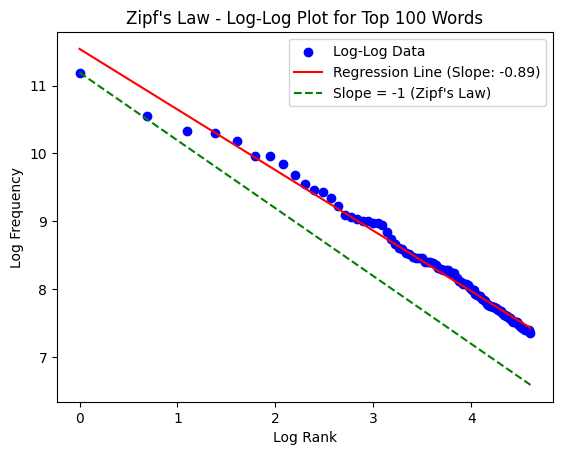

In [9]:
# Finding Ranks and Frequencies
ranks_100 = np.arange(1, len(top_words) + 1)
#print(ranks_100)

# Log Transformations
log_ranks_100 = np.log(ranks_100)
log_frequencies_100 = np.log(top_word_values)

# Econometric Regression
X_100 = sm.add_constant(log_ranks_100)
model_100 = sm.OLS(log_frequencies_100, X_100)
results_100 = model_100.fit()

# Graphing Results 
zipf_line_100 = log_frequencies_100[0] + (-1) * (log_ranks_100 - log_ranks_100[0])

plt.scatter(log_ranks_100, log_frequencies_100, color='blue', label='Log-Log Data')
plt.plot(log_ranks_100, results_100.predict(X_100), color='red', label=f'Regression Line (Slope: {results_100.params[1]:.2f})')
plt.plot(log_ranks_100, zipf_line_100, color='green', linestyle='--', label='Slope = -1 (Zipf\'s Law)')
plt.xlabel('Log Rank')
plt.ylabel('Log Frequency')
plt.title('Zipf\'s Law - Log-Log Plot for Top 100 Words')
plt.legend()
plt.show()

### Does it follow zipf's law?
In summary, the plot econometrically supports Zipf's Law by showing that the relationship between the log of word rank and the log of word frequency is approximately linear with a slope close to -1. This suggests that the dataset follows a power-law distribution, which is consistent with Zipf's Law.

# Task B

In [10]:
mergedmakemodel = pd.read_csv('merged-1.csv')
mergedmakemodel = mergedmakemodel.drop(['Unnamed: 0'], axis = 1)
mergedmakemodel

,make,model
0,acura,cl
1,acura,ilx
2,acura,integra
3,acura,legend
4,acura,mdx
...,...,...
1725,volkswagen,volkwagen
1726,volkswagen,vw
1727,volkswagen,vws
1728,volkswagen,passats


In [11]:
stop_words = set(stopwords.words('english'))
model_to_brand = dict(zip(mergedmakemodel['model'].str.lower(), mergedmakemodel['make'].str.lower()))
brands_set = set(model_to_brand.values())

def replacements(message, model_to_brand, brands_set):
    if not isinstance(message, str):
        message = ''
    words = re.findall(r'\w+', message.lower())
    replaced_words = [model_to_brand.get(word, word) for word in words]
    return set([word for word in replaced_words if word not in stop_words and word in brands_set])

messages = df['Message']
brand_counter = Counter()

for message in messages:
    brands = replacements(message, model_to_brand, brands_set)
    brand_counter.update(brands)

brands_to_remove = ['car', 'sedan', 'problem', 'seat', 'mini']

for brand in brands_to_remove:
    brand_counter.pop(brand, None)

top_10 = brand_counter.most_common(10)

print("Top 10 Brands by Frequency:")
for brand, count in top_10:
    print(f"{brand.capitalize()}: {count}")

Brand_Counterdf = pd.DataFrame(brand_counter, columns = ['Brand', 'Count'])

Top 10 Brands by Frequency:
Infiniti: 11162
Lexus: 9380
Bmw: 5111
Acura: 3232
Polestar: 2365
Audi: 2234
Honda: 1691
Cadillac: 1319
Toyota: 1000
Nissan: 835


# Task C

In [12]:
# File paths
wordcounts_file = 'brand_counts.csv'
replacement_words_file = 'merged-1.csv'
input_file = 'replaced_data.csv'

def clean_text(text):
    # Remove punctuation, convert to lowercase, and remove stopwords
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return [word for word in text.split() if word not in stop_words]

def load_word_counts(filename):
    word_counts = {}
    with open(filename, 'r') as file:
        for line in file:
            try:
                word, count = line.strip().split(',')
                word_counts[word] = int(count)
            except ValueError:
                continue
    return dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

def load_replacement_words(filename):
    df = pd.read_csv(filename)
    valid_brands = set(df['make'].unique())
    valid_brands -= {'car', 'seat', 'problem', 'sedan'}  # Exclude unwanted words
    return valid_brands

def get_top_brands(word_counts, valid_brands):
    top_brands = [word for word in word_counts if word in valid_brands]
    return top_brands[:10]  # Limit to 10 brands

def process_input_file(input_filename):
    posts = []
    with open(input_filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            post = clean_text(row[1])  # Assuming post text is in the second column
            posts.append(post)
    return posts


def calculate_lift_for_brands(posts, top_brands, max_distance=5):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))
    total_posts = len(posts)

    # Count brand frequencies and co-occurrences
    for post in posts:
        unique_words = set(post)
        brand_positions = {brand: [] for brand in top_brands}  # Track positions of top brands in the post

        # Record positions of the top brands in the post
        for index, word in enumerate(post):
            if word in top_brands:
                brand_positions[word].append(index)

        # Count brand frequencies (mention once per post, even if it appears multiple times)
        for brand in brand_positions:
            if brand_positions[brand]:  # If the brand appeared in the post
                word_frequency[brand] += 1

        # Check for co-occurrences within the max_distance
        for brand1, brand2 in itertools.combinations(top_brands, 2):
            if brand_positions[brand1] and brand_positions[brand2]:
                # Check if any pair of positions is within max_distance
                for pos1 in brand_positions[brand1]:
                    for pos2 in brand_positions[brand2]:
                        if abs(pos1 - pos2) <= max_distance:
                            word_pair_frequency[brand1][brand2] += 1
                            word_pair_frequency[brand2][brand1] += 1  # Ensure both directions are updated
                            break  # Only count once per post

    # Calculate lift values
    lift_values = []
    for brand1, brand2 in itertools.combinations(top_brands, 2):
        p_word1_and_word2 = word_pair_frequency[brand1][brand2] / total_posts
        p_word1 = word_frequency[brand1] / total_posts
        p_word2 = word_frequency[brand2] / total_posts
        if p_word1 > 0 and p_word2 > 0:
            lift_value = p_word1_and_word2 / (p_word1 * p_word2)
            lift_values.append({'word1': brand1, 'word2': brand2, 'lift_value': lift_value})
            lift_values.append({'word1': brand2, 'word2': brand1, 'lift_value': lift_value})  # Symmetric value

    # Convert to DataFrame
    df_lift = pd.DataFrame(lift_values)

    # Format and print the lift matrix
    lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    lift_matrix = lift_matrix.fillna(0)  # Fill missing values with 0

    print("\nFormatted Lift Matrix:\n")
    print(lift_matrix.to_string())  # Print matrix in a formatted chart style

    return df_lift, lift_matrix

# Main script
word_counts = load_word_counts(wordcounts_file)
valid_brands = load_replacement_words(replacement_words_file)
top_brands = get_top_brands(word_counts, valid_brands)
posts = process_input_file(input_file)
df_lift, lift_matrix = calculate_lift_for_brands(posts, top_brands)


Formatted Lift Matrix:

word2        acura      audi       bmw  cadillac     honda  infiniti     lexus    nissan  polestar    toyota
word1                                                                                                       
acura     0.000000  1.305416  0.691702  0.777237  1.555565  1.474570  1.298838  0.626996  0.464038  0.448055
audi      1.305416  0.000000  1.050984  1.281457  0.352790  1.131131  0.972045  0.302316  0.573422  0.224631
bmw       0.691702  1.050984  0.000000  0.881988  0.352385  1.218241  1.228950  0.273750  0.561806  0.378621
cadillac  0.777237  1.281457  0.881988  0.000000  0.244809  1.061159  1.191893  0.166168  0.314284  0.230475
honda     1.555565  0.352790  0.352385  0.244809  0.000000  0.722378  0.667641  1.542792  0.538704  2.337375
infiniti  1.474570  1.131131  1.218241  1.061159  0.722378  0.000000  1.215312  1.146625  0.681411  0.585008
lexus     1.298838  0.972045  1.228950  1.191893  0.667641  1.215312  0.000000  0.804066  0.541481  0.8

# Task D

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


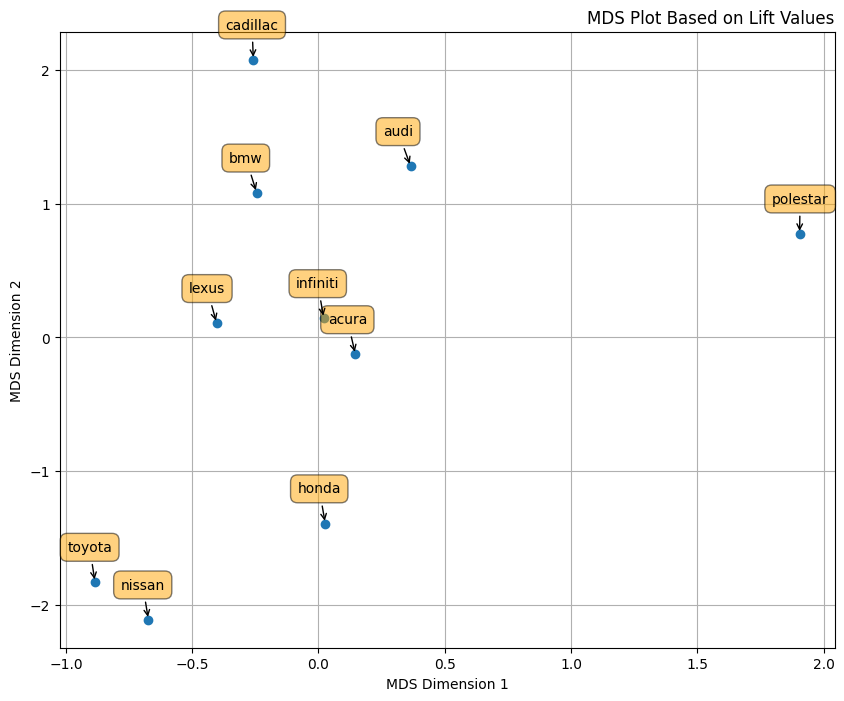

In [13]:
dissimilarity_matrix = 1 / (lift_matrix + 1e-10)
np.fill_diagonal(dissimilarity_matrix.values, 0)  # Set diagonal to zero

# Multidimensional Scaling (MDS)
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
                   random_state=seed, dissimilarity="precomputed")

try:
    results = mds.fit(dissimilarity_matrix)
    coords = results.embedding_
    
except ValueError as e:
    print(f"Error during MDS fitting: {e}")
    coords = np.zeros((len(lift_matrix), 2))  # Placeholder in case of error

# Plotting the MDS results
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], marker='o')

# Annotate each point with the corresponding brand name
for label, x, y in zip(lift_matrix.index, coords[:, 0], coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-20, 20),
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Left-align the title
plt.title('MDS Plot Based on Lift Values', loc='right')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()

# Task E

- 3 clusters of brands, 2 luxury, 1 entry level 
- polestar is an outlier
- lexus, infinity, accura are middle man brands entry level and luxury

# Task F

In [15]:
import nltk
nltk.download('punkt')  # For tokenizers
nltk.download('stopwords')  # If you're using stopwords
nltk.download('averaged_perceptron_tagger')  # If you need POS tagging
# Add any other nltk datasets you need to download

[nltk_data] Downloading package punkt to /Users/krummelha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krummelha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/krummelha/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [22]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Assuming 'df' contains the text of the discussions in a column called 'Message'

# A list of car-related attributes to look for (this can be expanded based on your data)
attributes = ["speed", "comfort", "design", "performance", "price", "safety", "interior", "fuel", "handling", "reliability"]

# Preprocessing and tokenizing the discussions
def preprocess_text(text):
    # Ensure text is a string
    if isinstance(text, str):
        # Lowercasing, removing non-alphanumeric characters
        text = re.sub(r'[^\w\s]', '', text.lower())
        
        # Tokenizing the text
        tokens = word_tokenize(text)
        
        # Removing stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        return tokens
    else:
        return []

# Apply the preprocessing and tokenizing function to the 'Message' column
df['tokens'] = df['Message'].apply(clean_text)

# Flatten the list of tokens and count the frequency of attributes
all_tokens = [token for sublist in df['tokens'] for token in sublist]
attribute_counts = Counter([word for word in all_tokens if word in attributes])

# Get the 5 most frequently mentioned attributes
top_5_attributes = attribute_counts.most_common(5)
print(f"Top 5 Attributes: {top_5_attributes}")


AttributeError: 'float' object has no attribute 'translate'

In [24]:
import nltk
nltk.download('punkt')  # For tokenizing words
nltk.download('stopwords')  # For stopwords removal


[nltk_data] Downloading package punkt to /Users/krummelha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krummelha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the required resources
nltk.download('punkt')  # For tokenizing words
nltk.download('stopwords')  # For stopwords removal

# A list of car-related attributes to look for (this can be expanded based on your data)
attributes = ["speed", "comfort", "design", "performance", "price", "safety", "interior", "fuel", "handling", "reliability"]

# Preprocessing and tokenizing the discussions
def preprocess_text(text):
    # Ensure text is a string
    if isinstance(text, str):
        # Lowercasing, removing non-alphanumeric characters
        text = re.sub(r'[^\w\s]', '', text.lower())
        
        # Tokenizing the text
        tokens = word_tokenize(text)
        
        # Removing stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        return tokens
    else:
        return []

# Assuming 'df' contains the text of the discussions in a column called 'Message'
# Apply the preprocessing and tokenizing function to the 'Message' column
df['tokens'] = df['Message'].apply(preprocess_text)

# Flatten the list of tokens and count the frequency of attributes
all_tokens = [token for sublist in df['tokens'] for token in sublist]
attribute_counts = Counter([word for word in all_tokens if word in attributes])

# Get the 5 most frequently mentioned attributes
top_5_attributes = attribute_counts.most_common(5)
print(f"Top 5 Attributes: {top_5_attributes}")


[nltk_data] Downloading package punkt to /Users/krummelha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krummelha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/krummelha/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [19]:
df.head()

,Date,Message
0,03/23/2002,Entry level performance luxury sedans are a ho...
1,03/24/2002,I personally think that with a few tweaks the ...
2,03/25/2002,I am debating a new purchase and these two are...
3,03/25/2002,"Great handling, RWD, excellent engine and the ..."
4,03/25/2002,And no manual tranny. That may not matter to y...


In [17]:
import pandas as pd
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Assuming 'discussion_df' contains the text of the discussions in a column called 'message'

# A list of car-related attributes to look for (this can be expanded based on your data)
attributes = ["speed", "comfort", "design", "performance", "price", "safety", "interior", "fuel", "handling", "reliability"]

# Preprocessing and tokenizing the discussions
def preprocess_text(text):
    # Lowercasing, removing non-alphanumeric characters
    text = re.sub(r'[^\w\s]', '', text.lower())
    
    # Tokenizing the text
    tokens = word_tokenize(text)
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

# Apply the preprocessing and tokenizing function to the 'message' column
df['tokens'] = df['Message'].apply(preprocess_text)

# Flatten the list of tokens and count the frequency of attributes
all_tokens = [token for sublist in df['tokens'] for token in sublist]
attribute_counts = Counter([word for word in all_tokens if word in attributes])

# Get the 5 most frequently mentioned attributes
top_5_attributes = attribute_counts.most_common(5)
print(f"Top 5 Attributes: {top_5_attributes}")


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/Users/krummelha/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.11/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
# List of irrelevant words (like "car") to remove from the results
brands_to_exclude = ['car']

# Initialize counters for brand-attribute associations
brand_attribute_counter = {attr: Counter() for attr in top_5_attributes}

# Process each message in the dataset
for message in messages:
    brands_in_message, attributes_in_message = extract_brands_and_attributes(message, model_to_brand, brands_set, top_5_attributes)
    
    # Filter out irrelevant brands like "car"
    brands_in_message = brands_in_message - set(brands_to_exclude)
    
    # Count co-occurrences of each brand with each attribute
    for brand in brands_in_message:
        for attribute in attributes_in_message:
            brand_attribute_counter[attribute][brand] += 1

# Output the top 10 brands for each attribute and debug 'speed' attribute if needed
for attribute, brand_counts in brand_attribute_counter.items():
    top_10_brands = brand_counts.most_common(10)  # Get the top 10 brands
    
    # Debugging output for 'speed' to make sure it's correctly handled
    if attribute == 'speed':
        print(f"\nDEBUG: All brands associated with speed: {brand_counts}\n")
    
    print(f"Top 10 Brands for {attribute.capitalize()}:")
    for brand, count in top_10_brands:
        print(f"  {brand.capitalize()}: {count} mentions")
    print("\n")


In [ ]:
import pandas as pd

# List of irrelevant words (like "car") to remove from the results
brands_to_exclude = ['car','sedan','seat']

# Initialize counters for brand-attribute associations
brand_attribute_counter = {attr: Counter() for attr in top_5_attributes}

# Process each message in the dataset
for message in messages:
    brands_in_message, attributes_in_message = extract_brands_and_attributes(message, model_to_brand, brands_set, top_5_attributes)
    
    # Filter out irrelevant brands like "car"
    brands_in_message = brands_in_message - set(brands_to_exclude)
    
    # Count co-occurrences of each brand with each attribute
    for brand in brands_in_message:
        for attribute in attributes_in_message:
            brand_attribute_counter[attribute][brand] += 1

# Create a dictionary to store the top 10 brands for each attribute
top_10_brands_dict = {}

for attribute, brand_counts in brand_attribute_counter.items():
    top_10_brands = [brand for brand, count in brand_counts.most_common(10)]  # Get the top 10 brands
    top_10_brands_dict[attribute] = top_10_brands

# Convert the dictionary into a DataFrame
top_10_brands_df = pd.DataFrame.from_dict(top_10_brands_dict, orient='index', columns=[f'Rank {i+1}' for i in range(10)])

# Display the DataFrame
print(top_10_brands_df)

# Save to CSV
top_10_brands_df.to_csv('top_10_brands_per_attribute.csv', index=True)


In [ ]:
top_10_brands_df.reset_index()

# Task G 

# Task H

In [ ]:
import re
from collections import Counter
import pandas as pd

# List of aspirational phrases that indicate people are aspiring to have a brand
aspirational_phrases = [
    'i want this car', 'love', 'forever car', 'wish i had', 'dream car', 'desire', 'my favorite'
]

# Preprocessing the aspirational phrases to make them more flexible for matching
aspirational_phrases_regex = [re.escape(phrase) for phrase in aspirational_phrases]

# Define the top 5 attributes based on your previous analysis
top_5_attributes = ['performance', 'price', 'interior', 'handling', 'speed']

# Function to extract both brands and attributes from a message
def extract_brands_and_attributes(message, model_to_brand, brands_set, attributes):
    words = re.findall(r'\w+', message.lower())
    replaced_words = [model_to_brand.get(word, word) for word in words]
    
    brands_in_message = set([word for word in replaced_words if word in brands_set])
    attributes_in_message = set([word for word in words if word in attributes])
    
    return brands_in_message, attributes_in_message

# Function to check if a message contains any aspirational phrases
def contains_aspirational_phrase(message, aspirational_phrases_regex):
    message = message.lower()
    return any(re.search(phrase, message) for phrase in aspirational_phrases_regex)

# Initialize counter for brand-aspiration associations
aspirational_brand_counter = Counter()

# Process each message in the dataset
for message in df['Message']:
    if contains_aspirational_phrase(message, aspirational_phrases_regex):
        # Extract brands in the message
        brands_in_message, _ = extract_brands_and_attributes(message, model_to_brand, brands_set, top_5_attributes)
        # Update brand aspirational counter
        aspirational_brand_counter.update(brands_in_message)

# Rank the brands based on their association with aspirational phrases
top_aspirational_brands = aspirational_brand_counter.most_common()

# Display the results
print("Top Brands People Aspire to Have:")
for brand, count in top_aspirational_brands:
    print(f"{brand.capitalize()}: {count} mentions")

# Save the results to a CSV file
aspirational_df = pd.DataFrame(top_aspirational_brands, columns=['Brand', 'Mentions'])
aspirational_df.to_csv('aspirational_brands.csv', index=False)
